In [69]:
# Cell 1
from typing import NewType
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [70]:
# Cell 2
class Calibration:
    def __init__(self, mtx, dist):
        self.mtx = mtx
        self.dist = dist
        
    def __repr__(self):
        return 'Calibration({self.mtx}, {self.dist})'.format(self=self)

def calibrate_camera():
    # size of the board: 10x7, but the code wants the corners
    width = 9
    height = 6
    
    images = glob.glob("camera_cal/calibration*.jpg")
    
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image space
    
    # Prepare obj points
    objp = np.zeros((width*height, 3), np.float32)
    objp[:,:2] = np.mgrid[0:width,0:height].T.reshape(-1,2) # x,y coordinates

    shape = None
    
    for fname in images:
        
        # Read in the image in RGB
        img = mpimg.imread(fname)
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        shape = gray.shape[::-1]
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If corners are found, collect them
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (width, height), corners, ret)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return Calibration(mtx, dist)

def undistort_img(calibration, img):
    undist = cv2.undistort(img, calibration.mtx, calibration.dist, None, calibration.mtx)
    return undist

camera_calibration = calibrate_camera()

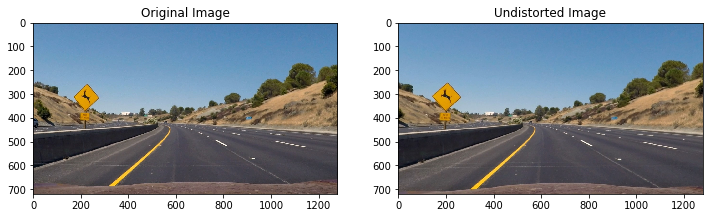

In [71]:
# Cell 3
def example_image_undistort(path):
    img = mpimg.imread(path)
    undist = undistort_img(camera_calibration, img)
    plt.figure(figsize=(12,9))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.title('Undistorted Image')
    plt.imshow(undist)
    
#example_image_undistort("camera_cal/calibration4.jpg")
example_image_undistort("test_images/test2.jpg")

In [125]:
# Cell 4

def mag_thresh(sobelx, sobely, mag_thresh=(50, 255)):
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(sobelx, sobely, thresh=(0.7, 1.2)):
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def color_threshold(undistorted, s_thresh=(170, 255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    return s_binary

def thresholded_binary_image(undistorted):
    sobel_kernel = 3
    # Convert to grayscale
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    mag_binary = mag_thresh(sobelx, sobely)
    dir_binary = dir_threshold(sobelx, sobely)
    color_binary = color_threshold(undistorted)
    
    combined = np.zeros_like(dir_binary)
    combined[((color_binary == 1) & ((mag_binary == 1) | (dir_binary == 1)))] = 1
    return color_binary

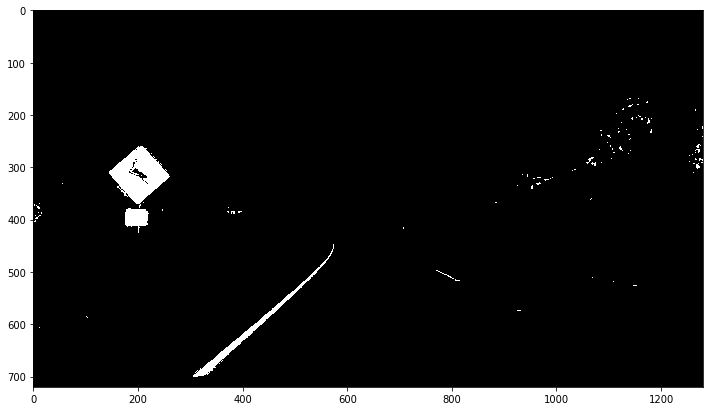

In [127]:
def example_thresholded_binary_image():
    img = mpimg.imread("test_images/test2.jpg")
    undist = undistort_img(camera_calibration, img)
    plt.figure(figsize=(12,9))
    plt.imshow(thresholded_binary_image(undist), cmap='gray')
    
example_thresholded_binary_image()